<a href="https://colab.research.google.com/github/b4wolf/NEURALNETS/blob/development/model_lstm_12_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from sklearn.impute import SimpleImputer

In [ ]:
!pip install torch.geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import timedelta
import os
from google.colab import files
torch.manual_seed(1)
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.nn import GCNConv

# Ignore everything above

In [ ]:
"""def impute_data(raw_data_path, year):
  df = pd.read_parquet(raw_data_path)
  df_filtered = df[df['valid'].dt.year.isin([2021, 2021])]
  df = pd.DataFrame(df_filtered)
  df = df.set_index('valid')
  df.index = df.index.floor('H')

  start_date = pd.to_datetime(f'{year}-01-01').floor('D')
  end_date = pd.to_datetime(f'{year+1}-01-01').floor('D') - timedelta(hours=1)
  complete_index = pd.date_range(start=start_date, end=end_date, freq='1H')
  complete_df = pd.DataFrame(index=complete_index)

  merged_df = complete_df.merge(df, left_index=True, right_index=True, how='left')
  merged_df = merged_df[~merged_df.index.duplicated(keep='first')]
  imputed_df = merged_df.fillna(method='ffill')
  return imputed_df

for filename in os.listdir('./raw_WI_data'):
    if '.parquet' not in filename:
      continue
    dataframe = impute_data('./raw_WI_data/' + filename, 2021)
    if len(dataframe) == 8760:
      file = dataframe.to_csv(f'./clean_WI_data/{filename[:3]}.csv')
"""

"def impute_data(raw_data_path, year):\n  df = pd.read_parquet(raw_data_path)\n  df_filtered = df[df['valid'].dt.year.isin([2021, 2021])]\n  df = pd.DataFrame(df_filtered)\n  df = df.set_index('valid')\n  df.index = df.index.floor('H')\n\n  start_date = pd.to_datetime(f'{year}-01-01').floor('D')\n  end_date = pd.to_datetime(f'{year+1}-01-01').floor('D') - timedelta(hours=1)\n  complete_index = pd.date_range(start=start_date, end=end_date, freq='1H')\n  complete_df = pd.DataFrame(index=complete_index)\n\n  merged_df = complete_df.merge(df, left_index=True, right_index=True, how='left')\n  merged_df = merged_df[~merged_df.index.duplicated(keep='first')]\n  imputed_df = merged_df.fillna(method='ffill')\n  return imputed_df\n\nfor filename in os.listdir('./raw_WI_data'):\n    if '.parquet' not in filename:\n      continue\n    dataframe = impute_data('./raw_WI_data/' + filename, 2021)\n    if len(dataframe) == 8760:\n      file = dataframe.to_csv(f'./clean_WI_data/{filename[:3]}.csv')\n"

In [ ]:
station_data = []
for filename in os.listdir('.'):
  if '.csv' in filename:
    pm25_df = pd.read_csv(filename)
    station_data.append(np.array(pm25_df["Value"].values).reshape(-1, 1))

In [ ]:
# from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
# Creates a series of lookback windows to be used for training and predicting window t+1
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

In [ ]:
# NORMALIZING
normalized_station_data = []
for stat in station_data:
  train_size = int(len(stat) * 0.70)
  test_size = len(stat) - train_size

  #stat = stat.astype('float32')
  stat_train, stat_test = stat[:train_size], stat[train_size:]
  #scaler = preprocessing.StandardScaler().fit(stat_train)
  #stat_train = scaler.transform(stat_train)
  #stat_test = scaler.transform(stat_test)

  normalized_station_data.append([stat_train, stat_test])

print(len(normalized_station_data))

17


In [ ]:
lookback = 7
station_train_dataset = []
station_test_dataset = []
for stat in normalized_station_data:
  X_train, y_train = create_dataset(stat[0], lookback=lookback)
  X_test, y_test = create_dataset(stat[1], lookback=lookback)
  station_train_dataset.append([X_train, y_train])
  station_test_dataset.append([X_test, y_test])

In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=100, out_features=input_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
def plot(model, timeseries, train_size, X_train, y_train, X_test, y_test):
  with torch.no_grad():
      # shift train predictions for plotting
      train_plot = np.ones_like(timeseries[:,0]) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1, 0]
      train_plot[lookback:train_size] = y_pred
      # shift test predictions for plotting
      y_pred = model(X_test)
      y_pred = y_pred[:, -1, 0]
      test_plot = np.ones_like(timeseries[:,0]) * np.nan
      test_plot[train_size+lookback:len(timeseries[:,0])] = y_pred
  # plot
  plt.plot(timeseries[:,0], c='b')
  plt.show()
  plt.plot(train_plot, c='r')
  plt.plot(test_plot, c='g')
  #plt.xlim(7250, 7750)
  plt.show()

PM 2.5 Model
Epoch 0: train RMSE 2.2252, test RMSE 2.1870, train R2 0.8953, test R2 0.8122


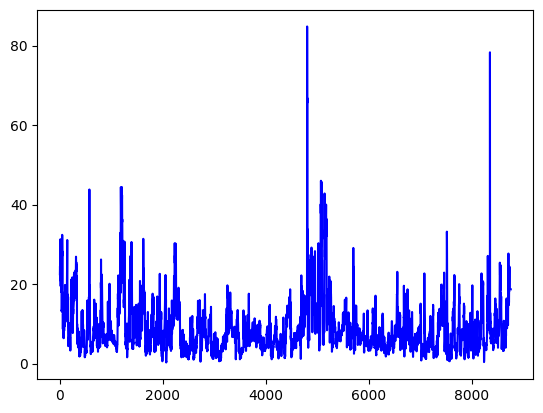

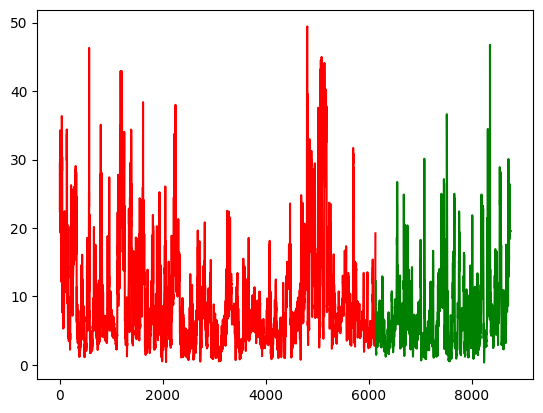

PM 2.5 Model
Epoch 0: train RMSE 2.3732, test RMSE 1.9044, train R2 0.9088, test R2 0.8541


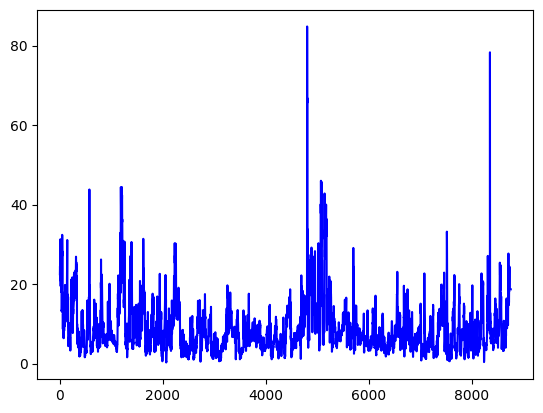

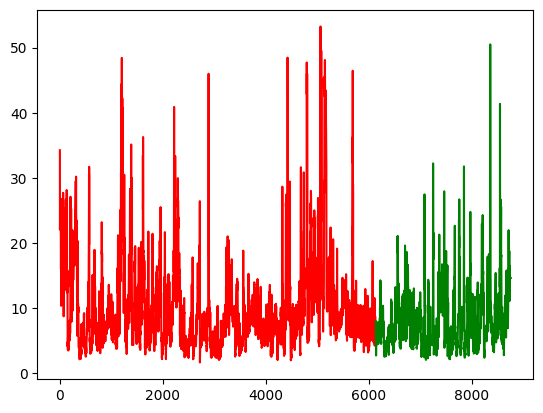

PM 2.5 Model
Epoch 0: train RMSE 1.7441, test RMSE 2.2663, train R2 0.9287, test R2 0.8313


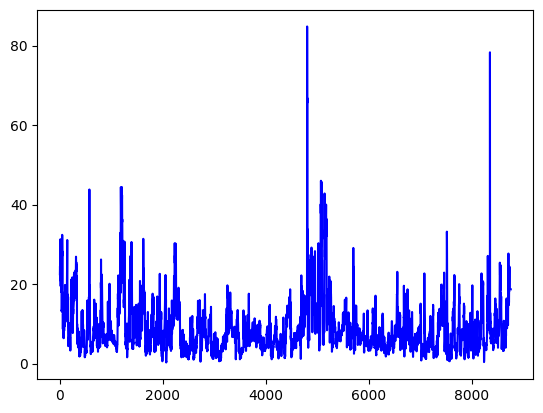

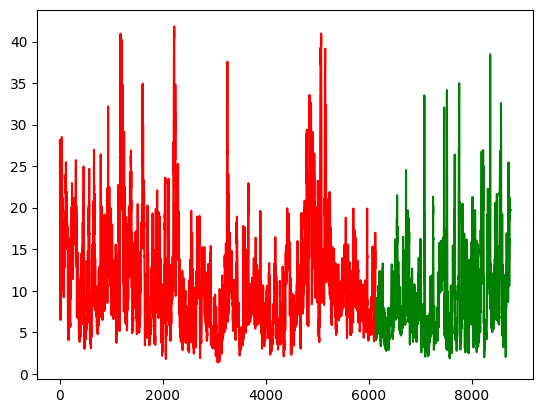

PM 2.5 Model
Epoch 0: train RMSE 4.1715, test RMSE 3.3200, train R2 0.7164, test R2 0.7383


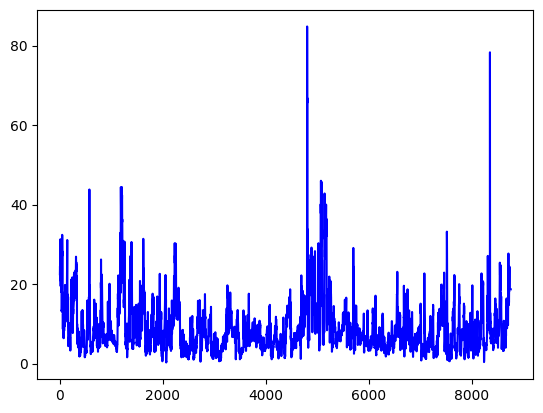

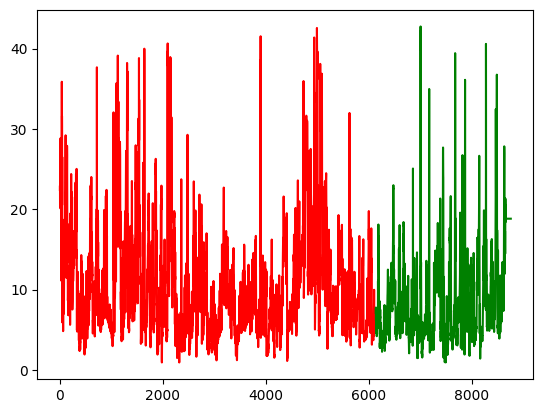

PM 2.5 Model
Epoch 0: train RMSE 3.5586, test RMSE 1.6730, train R2 0.8501, test R2 0.8376


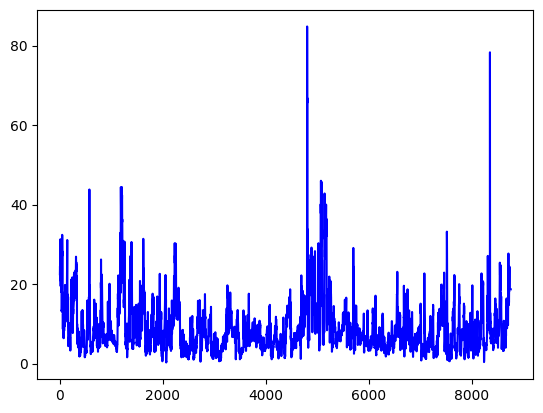

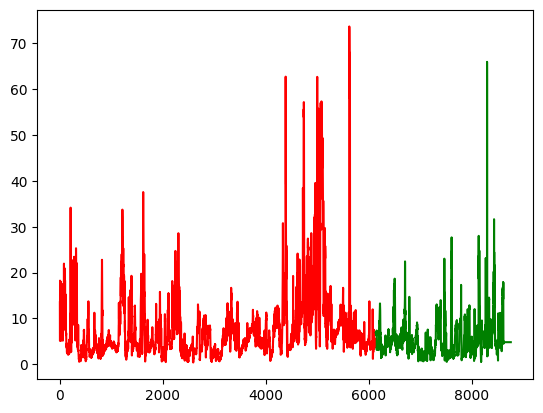

PM 2.5 Model
Epoch 0: train RMSE 3.4433, test RMSE 1.6511, train R2 0.8688, test R2 0.8287


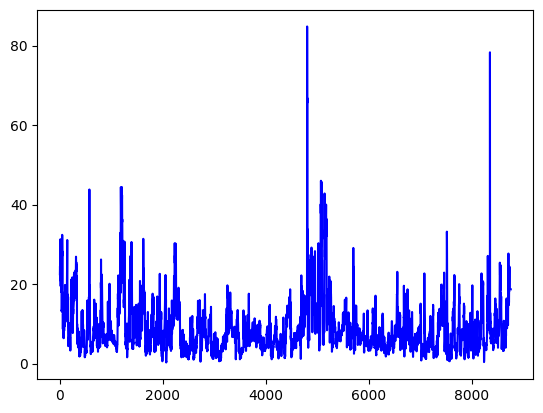

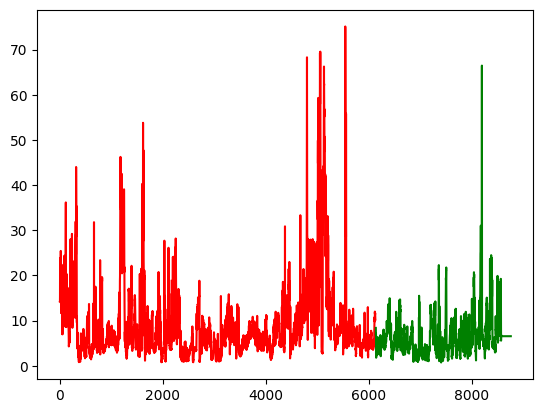

PM 2.5 Model
Epoch 0: train RMSE 1.7245, test RMSE 2.2666, train R2 0.9386, test R2 0.7868


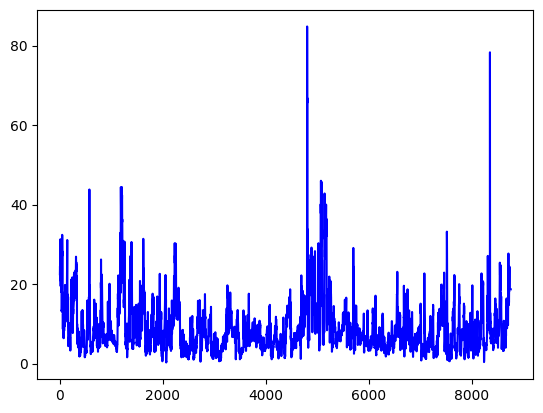

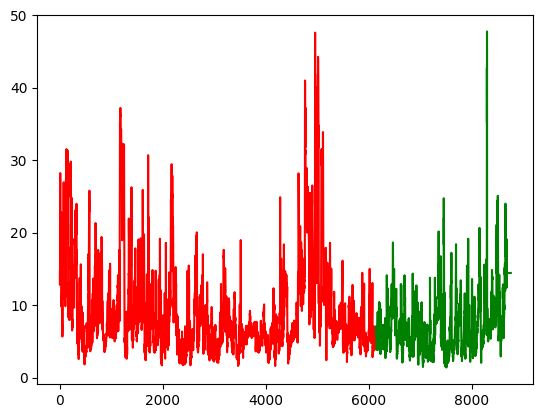

PM 2.5 Model
Epoch 0: train RMSE 2.3871, test RMSE 2.6712, train R2 0.8929, test R2 0.8183


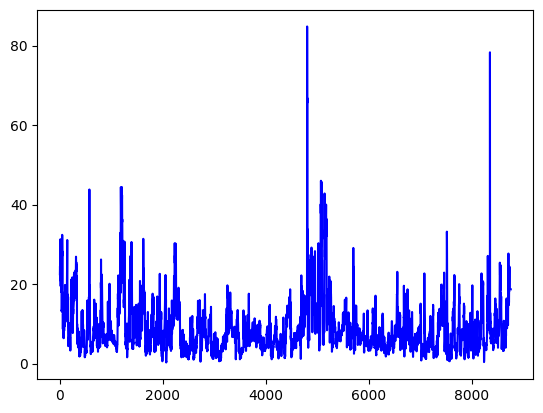

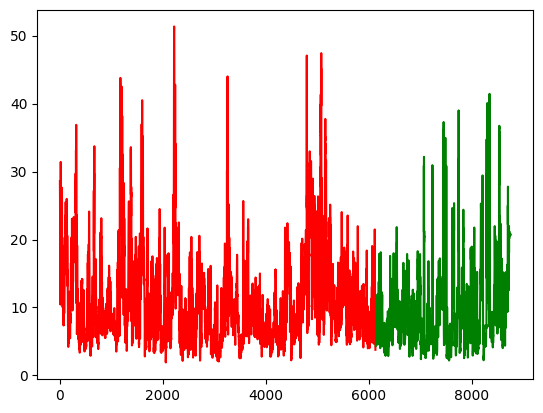

PM 2.5 Model
Epoch 0: train RMSE 1.6617, test RMSE 1.6765, train R2 0.9285, test R2 0.8527


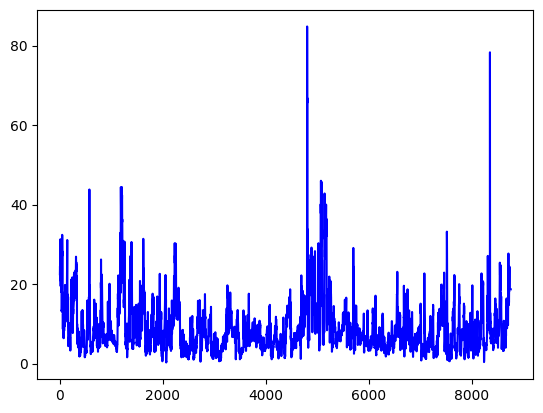

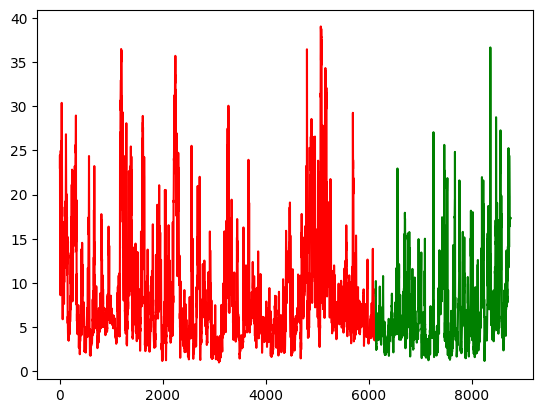

PM 2.5 Model
Epoch 0: train RMSE 3.8552, test RMSE 1.3731, train R2 0.7814, test R2 0.8634


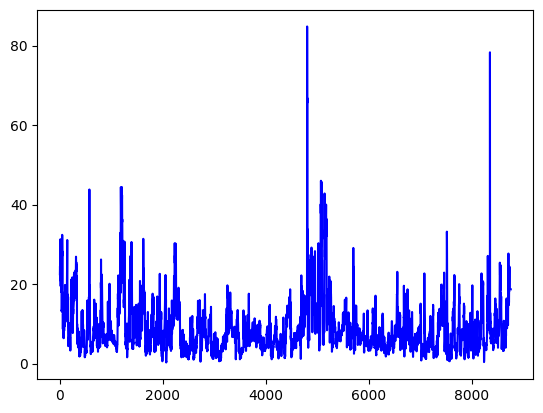

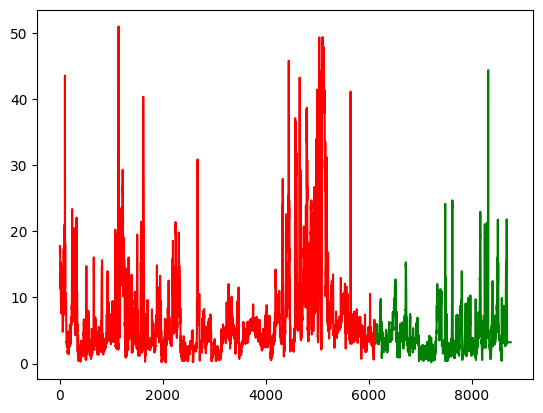

PM 2.5 Model
Epoch 0: train RMSE 2.3735, test RMSE 2.4762, train R2 0.8905, test R2 0.8063


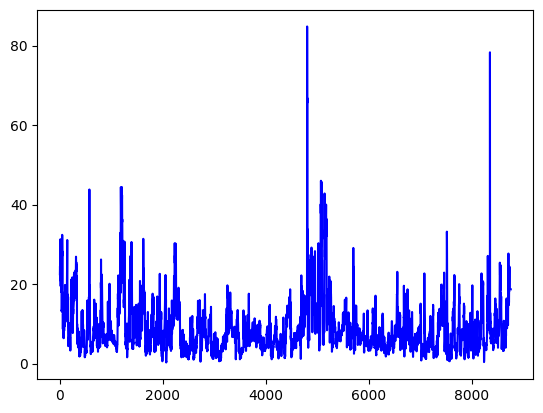

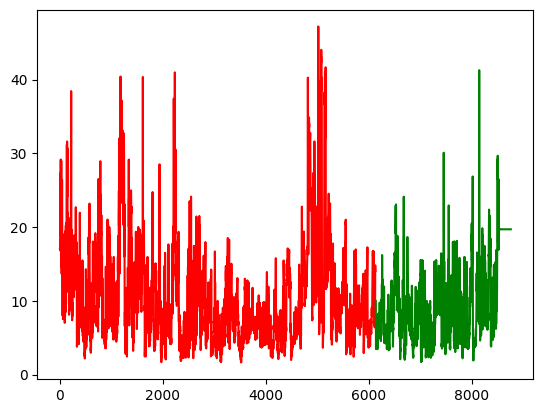

PM 2.5 Model
Epoch 0: train RMSE 1.9810, test RMSE 2.3683, train R2 0.9205, test R2 0.8059


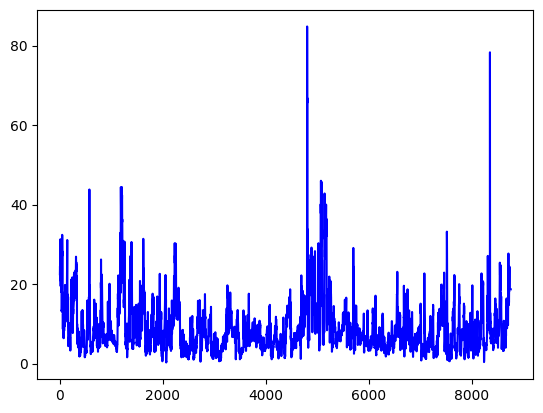

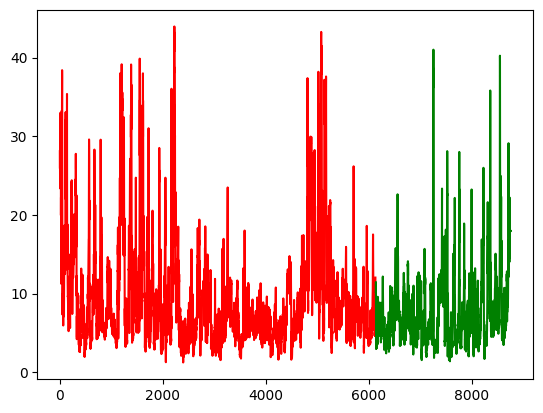

PM 2.5 Model
Epoch 0: train RMSE 3.8175, test RMSE 1.8803, train R2 0.8023, test R2 0.7884


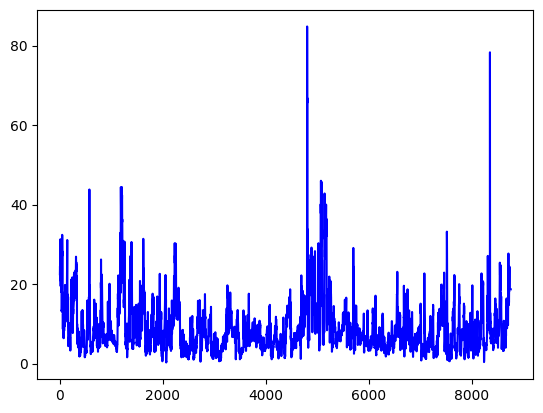

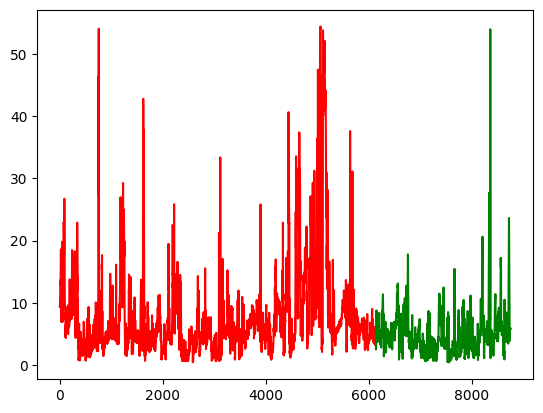

PM 2.5 Model
Epoch 0: train RMSE 2.1670, test RMSE 2.4947, train R2 0.9383, test R2 0.7667


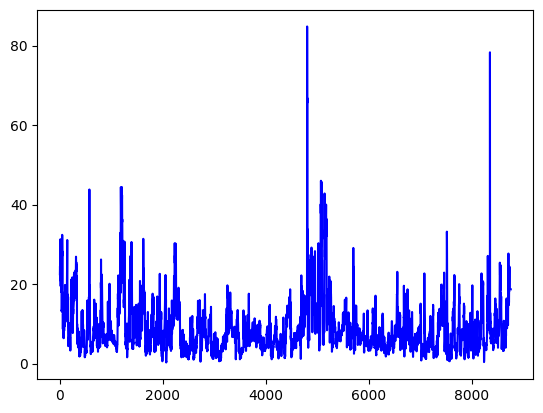

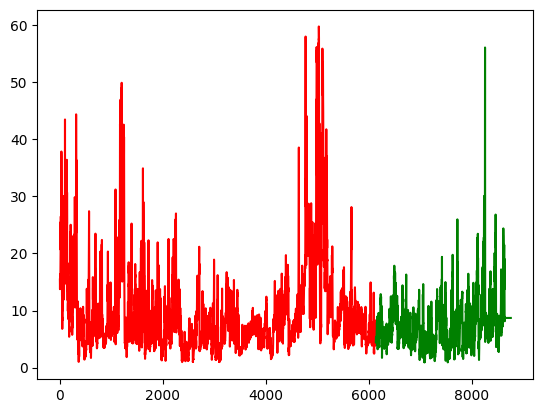

PM 2.5 Model
Epoch 0: train RMSE 2.5626, test RMSE 2.1333, train R2 0.9016, test R2 0.8592


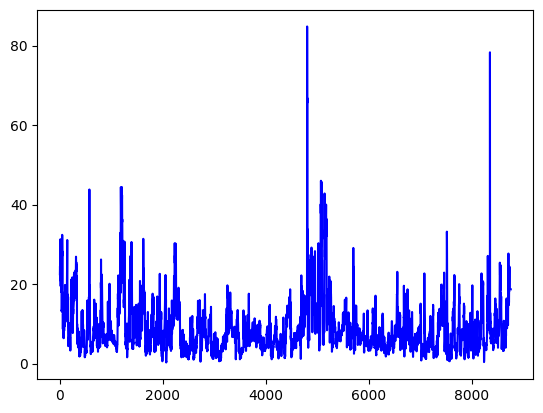

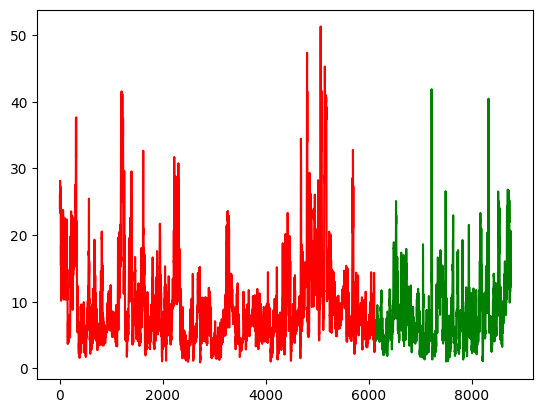

PM 2.5 Model
Epoch 0: train RMSE 2.1805, test RMSE 2.5224, train R2 0.9108, test R2 0.8405


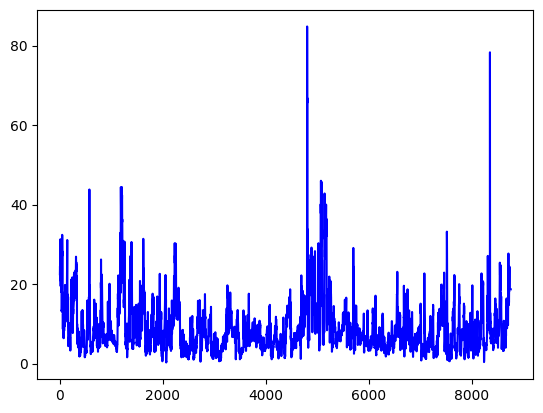

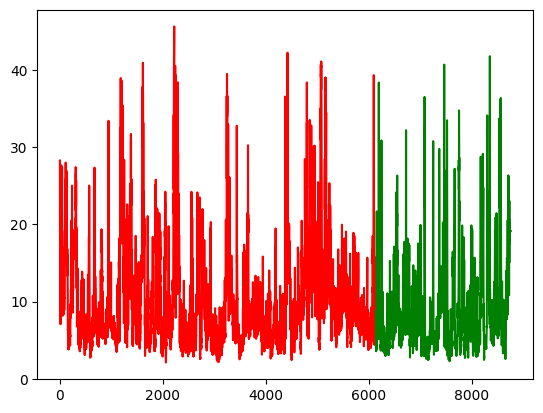

PM 2.5 Model
Epoch 0: train RMSE 1.7748, test RMSE 1.7458, train R2 0.9305, test R2 0.8677


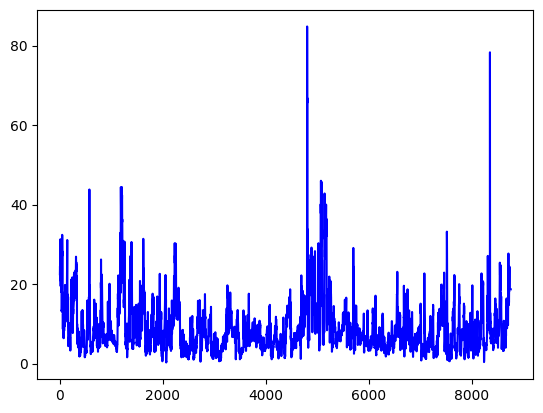

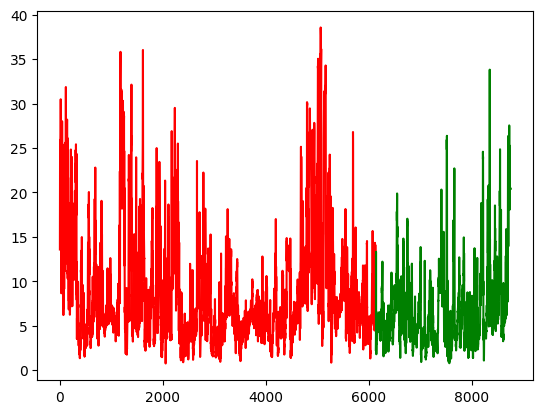

In [ ]:
import torch.optim as optim
import torch.utils.data as data

def r2_score(predicted, target):
    mean_target = torch.mean(target)
    total_variance = torch.sum((target - mean_target)**2)
    residual_variance = torch.sum((target - predicted)**2)
    r_squared = 1 - (residual_variance / total_variance)

    return r_squared.item()

for i in range(len(station_data)):
  X_train = torch.tensor(station_train_dataset[i][0], dtype=torch.float)
  y_train = torch.tensor(station_train_dataset[i][1], dtype=torch.float)
  X_test = torch.tensor(station_test_dataset[i][0], dtype=torch.float)
  y_test = torch.tensor(station_test_dataset[i][1], dtype=torch.float)

  loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
  n_epochs = 1
  loss_fn = nn.MSELoss()
  input_size = 1
  stat_train_predictions = []
  stat_test_predictions = []
  def models(loader, X_train, y_train, X_test, y_test):
    model = LSTM_Model(input_size)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    losses = []
    for epoch in range(n_epochs):
        model.train()
        avg_loss = []
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            avg_loss.append(loss.detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(np.mean(avg_loss))
        # Validation
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            stat_train_predictions.append(y_pred)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            r2_score_train = r2_score(y_pred, y_train)
            y_pred = model(X_test)
            stat_test_predictions.append(y_pred)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
            r2_score_test = r2_score(y_pred, y_test)

        print("Epoch %d: train RMSE %.4f, test RMSE %.4f, train R2 %.4f, test R2 %.4f" % (epoch, train_rmse, test_rmse, r2_score_train, r2_score_test))
    return model, losses

  print("PM 2.5 Model")
  pm25_model, pm25_losses = models(loader, X_train, y_train, X_test, y_test)
  plot(pm25_model, station_data[0], train_size, X_train, y_train, X_test, y_test)

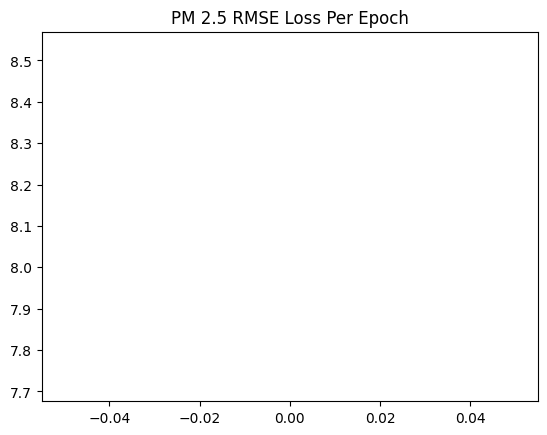

In [ ]:
plt.title("PM 2.5 RMSE Loss Per Epoch")
plt.plot(pm25_losses, label="pm25 loss")
plt.show()

# Try try again, closer version

note that the files for processed monitor are stored in content when on colab but might be different when local

In [ ]:
!pip install networkx torchvision

In [ ]:
import torch
import folium
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from scipy.spatial.distance import euclidean
import os
import networkx as nx
from torch_geometric.data import Data
import math
from heapq import nsmallest
import pandas as pd
import re
import glob
import matplotlib.pyplot as plt

In [ ]:
directory_path = '/content/'
file_names = [file for file in os.listdir(directory_path) if 'monitor' in file and file.endswith('.csv')]
data_frames = []

for file_name in file_names:
    match = re.match(r'processed_monitor_([0-9.-]+)_([0-9.-]+)\.csv', file_name)
    if match:
        lat, lon = match.groups()
        lat, lon = float(lat), float(lon)
        try:
            df = pd.read_csv(os.path.join(directory_path, file_name))
            df['Latitude'] = lat
            df['Longitude'] = lon
            data_frames.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_name}")
        except pd.errors.EmptyDataError:
            print(f"No data in file: {file_name}")
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
    else:
        print(f"Filename pattern mismatch: {file_name}")

In [ ]:
directory_path = '/content/'
file_names = glob.glob(os.path.join(directory_path, '*.csv'))

In [ ]:
nodes = list(range(len(data_frames)))

In [67]:
def haversine(coord1, coord2):
    R = 6371.0
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

G = nx.Graph()

distances = {}
for i in range(len(data_frames)):
    distances[i] = []
    coord1 = (data_frames[i]['Latitude'].iloc[0], data_frames[i]['Longitude'].iloc[0])
    for j in range(len(data_frames)):
        if i != j:
            coord2 = (data_frames[j]['Latitude'].iloc[0], data_frames[j]['Longitude'].iloc[0])
            distance = haversine(coord1, coord2)
            distances[i].append((distance, j))

for i, dist_list in distances.items():
    three_nearest = nsmallest(3, dist_list)
    for dist, j in three_nearest:
        G.add_edge(i, j, weight=dist)


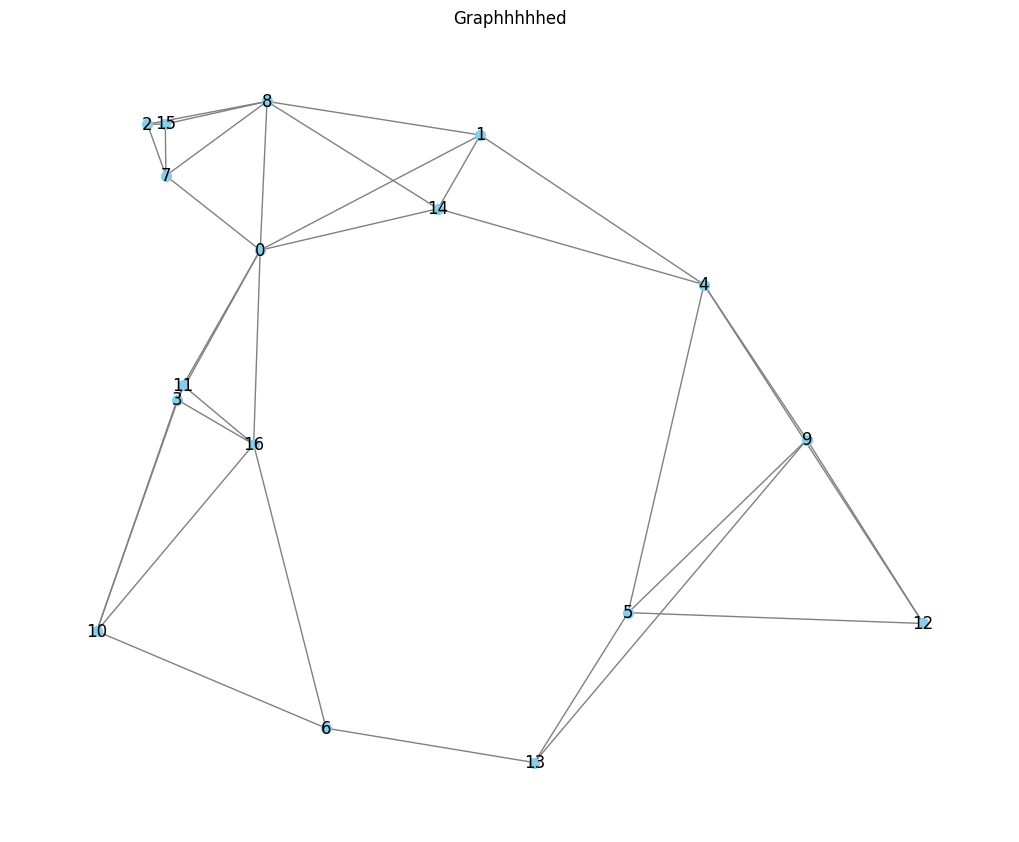

In [122]:
G = nx.Graph()
distances = {}
node_positions = {}

for i in range(len(data_frames)):
    coord1 = (data_frames[i]['Latitude'].iloc[0], data_frames[i]['Longitude'].iloc[0])
    node_positions[i] = coord1
    distances[i] = []

    for j in range(len(data_frames)):
        if i != j:
            coord2 = (data_frames[j]['Latitude'].iloc[0], data_frames[j]['Longitude'].iloc[0])
            distance = haversine(coord1, coord2)
            distances[i].append((distance, j))

for i, dist_list in distances.items():
    three_nearest = nsmallest(3, dist_list)
    for dist, j in three_nearest:
        G.add_edge(i, j, weight=dist)

plt.figure(figsize=(10, 8))
nx.draw(G, pos=node_positions, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
plt.title("Graphhhhhed")
plt.show()


In [56]:
directory_path = '/content/'
pattern = re.compile(r'([0-9.-]+)_([0-9.-]+)\.csv')
lat_lon_pairs = []
for file_name in os.listdir(directory_path):
    if file_name.endswith('.csv'):
        match = pattern.search(file_name)
        if match:
            lat, lon = match.groups()
            lat_lon_pairs.append((float(lat), float(lon)))
print(lat_lon_pairs)

[(43.46611, -88.62111), (44.50729, -87.99344), (42.93257, -87.93434), (43.0733, -89.4358), (45.56498, -88.80859), (45.2066, -90.5972), (43.7775, -91.2269), (43.020075, -88.21507), (43.4983, -87.8102), (46.0519, -89.654), (42.69302, -90.69813), (43.10101, -89.35768), (46.60234, -90.65615), (44.76249, -91.41445), (44.30738, -88.39509), (43.01724, -87.93369), (43.4351, -89.67979)]


In [57]:
wisconsin_center = (44.5000, -89.5000)
map_wisconsin = folium.Map(location=wisconsin_center, zoom_start=7)
lat_lon_list = lat_lon_pairs

for lat, lon in lat_lon_list:
    folium.Marker(location=(lat, lon)).add_to(map_wisconsin)

In [141]:
num_nodes = data.num_nodes
train_size = int(num_nodes * 0.8)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:train_size] = True

num_features = 2

edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.tensor([[df['Value'].mean(), df['Value'].std()] for df in data_frames], dtype=torch.float)
targets = [df['Value'].mean() for df in data_frames]
data = Data(x=x, edge_index=edge_index, y=torch.tensor(targets, dtype=torch.float))
data.train_mask = train_mask

class BasicGNN(torch.nn.Module):
    def __init__(self, num_features):
        super(BasicGNN, self).__init__()
        self.conv1 = SAGEConv(num_features, 16)
        self.conv2 = SAGEConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x.squeeze()

model = BasicGNN(num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    out = out.view_as(data.y)
    assert out.shape[0] == data.num_nodes, "Output size does not match number of nodes"
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 134.22572326660156
Epoch 1, Loss: 112.23838806152344
Epoch 2, Loss: 83.37626647949219
Epoch 3, Loss: 68.01509857177734
Epoch 4, Loss: 38.94382095336914
Epoch 5, Loss: 40.746498107910156
Epoch 6, Loss: 37.70992660522461
Epoch 7, Loss: 28.096187591552734
Epoch 8, Loss: 15.33636474609375
Epoch 9, Loss: 19.422460556030273
Epoch 10, Loss: 23.084453582763672
Epoch 11, Loss: 24.724164962768555
Epoch 12, Loss: 36.452754974365234
Epoch 13, Loss: 37.830299377441406
Epoch 14, Loss: 20.920461654663086
Epoch 15, Loss: 22.34433937072754
Epoch 16, Loss: 14.53986644744873
Epoch 17, Loss: 16.970474243164062
Epoch 18, Loss: 11.929336547851562
Epoch 19, Loss: 13.305506706237793
Epoch 20, Loss: 11.518091201782227
Epoch 21, Loss: 10.292899131774902
Epoch 22, Loss: 14.225648880004883
Epoch 23, Loss: 6.351315021514893
Epoch 24, Loss: 10.047112464904785
Epoch 25, Loss: 18.215843200683594
Epoch 26, Loss: 16.169574737548828
Epoch 27, Loss: 17.207773208618164
Epoch 28, Loss: 12.854256629943848
Epo

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
accuracy = correct / data.test_mask.sum().item()

print(f'Accuracy: {accuracy}')


# might be useful idk (Graveyard coded)

In [138]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# for epoch in range(50):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     loss = criterion(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch {epoch}, Loss: {loss.item()}')


In [139]:
# edge_index = torch.tensor(list(G.edges)).t().contiguous()
# # stensor = tensor([[ 0,  0,  0,  0,  0,  0,  0,  7,  7,  7,  8,  8,  8,  8, 11, 11, 11,  1,1, 14,  2,  3,  3, 16, 16,  4,  4,  4,  9,  9,  9,  5,  5, 13,  6],[ 7,  8, 11,  1,  3, 14, 16,  2, 15,  8,  1,  2, 15, 14,  3, 10, 16, 14,4,  4, 15, 16, 10,  6, 10,  9,  5, 12,  5, 12, 13, 13, 12,  6, 10]])
# x = torch.tensor([[df['Value'].mean(), df['Value'].std()] for df in data_frames], dtype=torch.float)
# data = Data(x=x, edge_index=edge_index)
# # data = Data(x=[17, 2], edge_index=[2, 35])
# num_features = 2
# num_classes = 8760

# regression_targets = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)
# targets_tensor = torch.tensor(regression_targets, dtype=torch.float)
# data = Data(edge_index=edge_index, x=node_features)
# data.y = targets_tensor
# print(f'this is the true data {len(targets_tensor)}')
# # this is the true data 17
# print(data.shape)
# print(data.edge_index)

In [140]:
# num_nodes = data.num_nodes
# train_size = int(num_nodes * 0.8)

# train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# train_mask[:train_size] = True

# num_features = 2
# num_classes = 8760

# edge_index = torch.tensor(list(G.edges)).t().contiguous()

# x = torch.tensor([[df['Value'].mean(), df['Value'].std()] for df in data_frames], dtype=torch.float)
# regression_targets = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)
# targets_tensor = torch.tensor([df[['Value']].values for df in data_frames], dtype=torch.float)
# targets_tensor = targets_tensor.view(-1)
# targets = [df['Value'].mean() for df in data_frames]
# data = Data(x=x, edge_index=edge_index, y=targets_tensor)
# data.y = torch.tensor(targets, dtype=torch.float)

# # data.train_mask = train_mask
# # data.y = targets_tensor.view(-1)


# class BasicGNN(torch.nn.Module):
#     def __init__(self, num_features):
#         super(BasicGNN, self).__init__()
#         self.conv1 = SAGEConv(num_features, 16)
#         self.conv2 = SAGEConv(16, 1)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x.squeeze()


# model = BasicGNN(num_features)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

# # Training loop
# for epoch in range(50):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     # Reshape out if necessary
#     out = out.view_as(data.y)

#     # Check shapes
#     assert out.shape[0] == data.num_nodes, "Output size does not match number of nodes"

#     # Compute loss
#     loss = criterion(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch {epoch}, Loss: {loss.item()}')